# Result Exploration
This notebook helps to build functions for printing results of CNN training.

In [71]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from Scripts import Print_Functions as PF
from Scripts import Centralized_CNN as cNN

FIGURES = os.path.join(module_path, "Figures")

In [72]:
params = PF.PlotParams(
            dataset='Pain',
            experiment='Centralized',
            metric='F1_Score',
            legend_loc='lower right',
            num_format="{:5.1%}",
            max_epochs=None,
            label_spaces=4
)

In [77]:
def make_pain_plot(folder, params, final_epoch=29):
    files = os.listdir(folder)
    files = [os.path.join(folder, file) for file in files if file.endswith('{}.csv'.format(final_epoch))]
    files = sorted(files)
    
    legend = []
    for idx, file in enumerate(files):
        df = pd.read_csv(file)
        plt.plot(df[params.metric], color=params.colors[idx])
        for i, j in df[params.metric][:params.max_epochs].items():
            if not int(i) % params.label_spaces:
                plt.text(i, j, params.num_format.format(j), color='black',
                         bbox=dict(facecolor='white', edgecolor=params.colors[idx], boxstyle='round'))

        legend.append('Group 1 + {0:.0%}% Group 2'.format(0.1 * idx))


    plt.legend(legend, loc=params.legend_loc)
    plt.title('{} | {} | Group 1 + X% Group 2'.format(params.metric, params.experiment))
    plt.yticks(np.arange(0.3, 1.05, step=0.05))
    plt.ylabel('{}'.format(params.metric))
    plt.xlabel('Epochs / Communication Rounds')
#     file = time.strftime("%Y-%m-%d-%H%M%S") + r"_{}_{}_{}.png".format(params.dataset, params.experiment, params.metric)
#     fig = plt.gcf()
#     fig.set_size_inches((12, 8), forward=False)
#     plt.savefig(os.path.join(FIGURES, file), dpi=300)
#     plt.show()
#     plt.clf()
    return plt

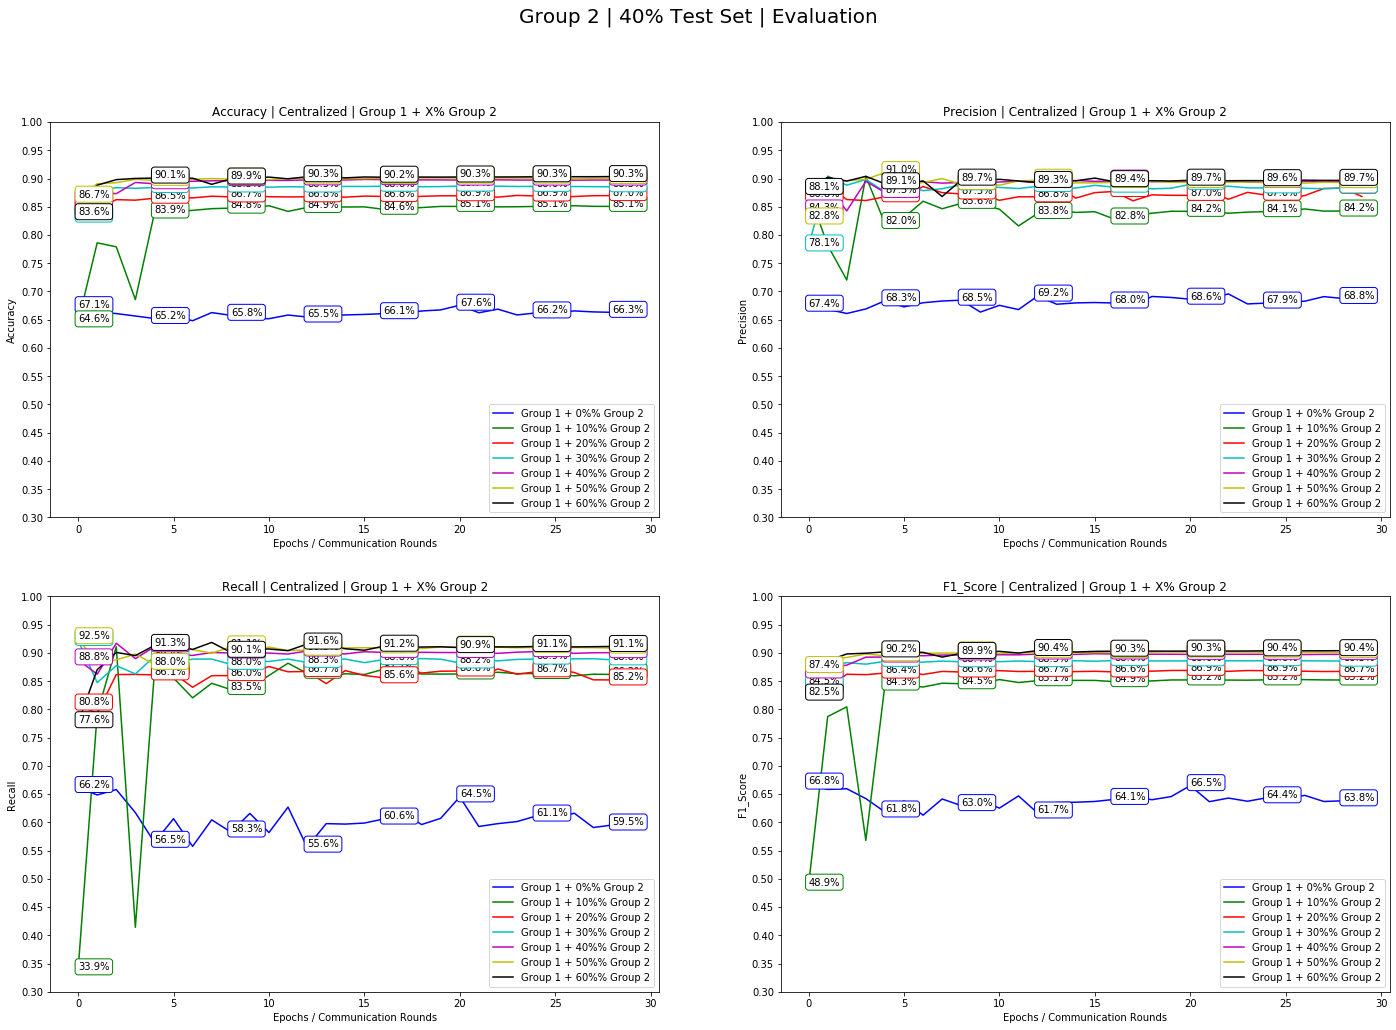

In [78]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1_Score']
for idx, metric in enumerate(metrics):
    params.metric = metric
    plt.subplot(2, 2, idx+1)
    plt = make_pain_plot(cNN.RESULTS, params=params)

plt.subplots_adjust(wspace=0.2, hspace=0.2)
file = time.strftime("%Y-%m-%d-%H%M%S") + r"_{}_{}_{}.png".format(params.dataset, params.experiment, str(metrics))
fig = plt.gcf()
fig.suptitle('Group 2 | 40% Test Set | Evaluation', fontsize=20)
fig.set_size_inches((24, 16), forward=False)
plt.savefig(os.path.join(FIGURES, file), dpi=300)